In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Setup

In [3]:
df = pd.read_excel("stock_ardl3.xlsx")
df.index = pd.to_datetime(df.date)
df = df.loc[df.date > '2003-01-01']
#df['ibov'] = np.log(df['ibov'])
#df['exchange_rate'] = np.log(df['exchange_rate'])

# Exploratory analysis

In [4]:
def plot_acf_pacf(df_ts, lags=12):
    print(plot_acf(df_ts, lags=lags))
    print(plot_pacf(df_ts, lags=lags, method="ols"))

Figure(432x288)
Figure(432x288)


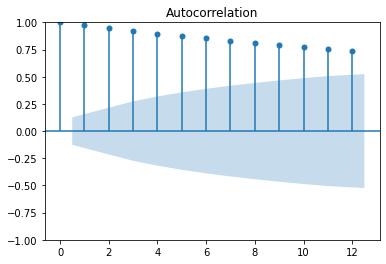

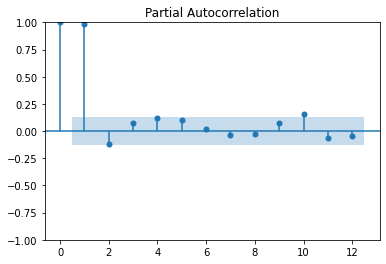

In [160]:
plot_acf_pacf(df.ibov)

Figure(432x288)
Figure(432x288)


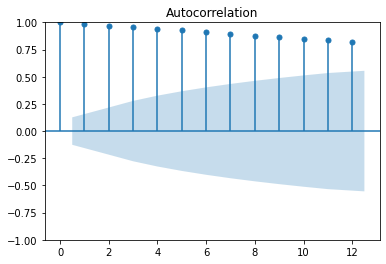

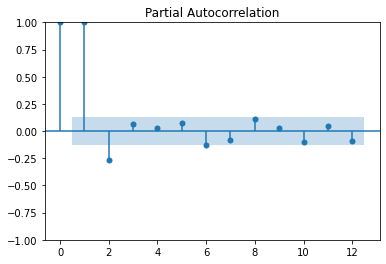

In [161]:
plot_acf_pacf(df.exchange_rate)

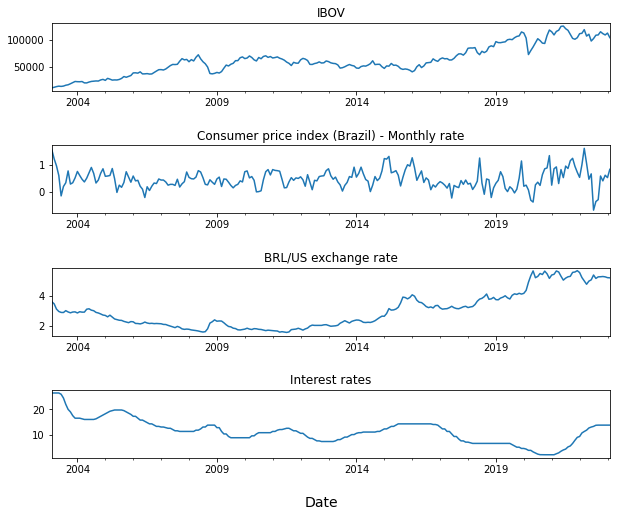

In [5]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.8})

# Convert the index to datetime
df.index = pd.to_datetime(df.date)

# Plot each time series in a separate subplot
df['ibov'].plot(ax=axs[0], label='Series 1')
axs[0].set_title('IBOV')
df['cpi_inflation'].plot(ax=axs[1], label='Series 2')
axs[1].set_title('Consumer price index (Brazil) - Monthly rate')
df['exchange_rate'].plot(ax=axs[2], label='Series 3')
axs[2].set_title('BRL/US exchange rate')
df['interest_rates'].plot(ax=axs[3], label='Series 4')
axs[3].set_title('Interest rates')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')

fig.text(0.5, 0.04, 'Date', ha='center', fontsize=14)

# Display the plot
plt.show()

In [6]:
df[['ibov','cpi_inflation','exchange_rate','interest_rates']].describe()

,ibov,cpi_inflation,exchange_rate,interest_rates
count,241.000000,241.000000,241.000000,241.000000
mean,62554.605809,0.477380,2.997451,11.363029
std,27855.375385,0.341296,1.194111,4.840532
min,10281.000000,-0.680003,1.562500,2.000000
25%,45805.000000,0.259995,2.029700,8.000000
50%,58338.000000,0.449926,2.706100,11.250000
75%,76402.000000,0.670058,3.761100,14.000000
max,126802.000000,1.620050,5.654900,26.500000


# Engle-Granger cointegration test

In [12]:
from statsmodels.tsa.stattools import coint
engle_granger = coint(df['ibov'], df[['exchange_rate']])

print(
    f'''Engle-Granger statistic: {engle_granger[0]}'''
)
print(
    f'''p-value:{engle_granger[1]}'''
)

Engle-Granger statistic: -3.3912433678541185
p-value:0.043332415033122275


# Granger Causality

$$ 
IBOV = \beta_0 + \sum_{j=1}^{4}\beta_jIBOV_{t-j} + \sum_{j=1}^{4}\alpha_jER_{t-j} + \varepsilon_t \\\ 
\newline
ER = \beta_0 + \sum_{j=1}^{4}\beta_jER_{t-j} + \sum_{j=1}^{4}\alpha_jIBOV_{t-j} + \varepsilon_t

In [70]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlags=4
gc_res = grangercausalitytests(df[["ibov", "exchange_rate"]],maxlag=maxlags, verbose=False)

results = [
    {
        "f_statistic": np.round(gc_res[lag][0]["params_ftest"][0], 4),
        "p_value": np.round(gc_res[lag][0]["params_ftest"][1], 4),
        "lag":lag
    }
        for lag in range(1, maxlags+1)
]

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [71]:
pd.DataFrame(results, columns=list(results[0].keys()))

,f_statistic,p_value,lag
0,7.1763,0.0079,1
1,3.9103,0.0214,2
2,5.4560,0.0012,3
3,3.4030,0.0100,4


# ARDL model

$$ IBOV = \beta_0 + \sum_{j=1}^{6}\beta_1IBOV_{t-1} + \alpha_1ER_{t-1} + \gamma_1CPI_{t-1} + \delta_1IR_{t-1} + \varepsilon_t

In [13]:
# Setting the exogenous variables
exog=df.loc[:, ~df.columns.isin(["ibov", "date"])]
#exog=df[['exchange_rate']]

# Define the range of lag values to test
max_lags = 6
lags_range = range(1, max_lags+1)

# Initialize the list of AIC values for each lag combination
aic_list = []

# Loop over the range of lags and fit the ARDL model for each combination
for p in lags_range:
    for q in lags_range:
        model = ARDL(
            df.ibov, p, 
            exog, {i:list(range(1,q+1)) for i in exog.columns})
        results = model.fit()
        aic = results.aic
        aic_list.append((p, q, aic))

# Find the combination of lags that returns the lowest AIC value
best_lags = min(aic_list, key=lambda x: x[2])
print("Best combination of lags: ({}, {}) with AIC = {}".format(best_lags[0], best_lags[1], best_lags[2]))

Best combination of lags: (6, 1) with AIC = 4618.033898141823


/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py

In [14]:
model = ARDL(
    df.ibov, best_lags[0], 
    exog, {i:list(range(1,best_lags[1]+1)) for i in exog.columns}
    ).fit(cov_type="HC0")
print(model.summary())

                              ARDL Model Results                              
Dep. Variable:                   ibov   No. Observations:                  241
Model:               ARDL(6, 1, 1, 1)   Log Likelihood               -2298.017
Method:               Conditional MLE   S.D. of innovations           4272.084
Date:                Fri, 12 May 2023   AIC                           4618.034
Time:                        11:32:01   BIC                           4656.089
Sample:                    08-01-2003   HQIC                          4633.376
                         - 02-01-2023                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6138.4060   2411.470      2.546      0.012    1386.452    1.09e+04
ibov.L1               1.0280      0.098     10.534      0.000       0.836       1.220
ibov.L2              -0.

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
max_used_lags = max(best_lags[0], best_lags[1])
model.model.exog = model.model.exog[max_used_lags:]

- Durbin-Watson test for residuals

In [16]:
import statsmodels.api as sm

# Test for first-order serial correlation using the Durbin-Watson test
durbin_watson = sm.stats.stattools.durbin_watson(model.resid)

# Print the test result
print("Durbin-Watson statistic:", durbin_watson)

Durbin-Watson statistic: 2.0043969947699973


- Breusch-Godfrey test for serial correlation

In [21]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

#perform Breusch-Godfrey test at order p = 3
breusch_godfrey = acorr_breusch_godfrey(model, nlags=3)

# Print the test result
print("Breusch-Godfrey statistic:", breusch_godfrey[0])
print("Breusch-Godfrey p-value:", breusch_godfrey[1])

Breusch-Godfrey statistic: 0.883723097956865
Breusch-Godfrey p-value: 0.829353917250354


- Breusch-Pagan for heteroskedasticity

In [22]:
# Add a constant column to your independent variable array
x_with_const = sm.add_constant(model.model.exog)

# Run the Breusch-Pagan test for heteroscedasticity
bp_test = sm.stats.diagnostic.het_breuschpagan(model.resid, x_with_const)

# Print the test results
print('Breusch-Pagan test statistic: ', bp_test[0])
print('Breusch-Pagan test p-value: ', bp_test[1])

Breusch-Pagan test statistic:  12.340218136490252
Breusch-Pagan test p-value:  0.00630410669236367


- Jarque-Bera test for residuals

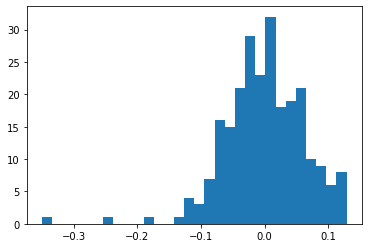

In [72]:
plt.hist(model.resid, bins=30)
fig = plt.gcf()
fig.set_facecolor("white")
plt.show()

In [73]:
import numpy as np
from scipy import stats

jarque_bera_test = stats.jarque_bera(model.resid)
jarque_bera_test

Jarque_beraResult(statistic=175.525817742568, pvalue=0.0)

In [256]:
print(jarque_bera_test.statistic)
print(jarque_bera_test.pvalue)

821.4781481769753
0.0


# Augmented Ducky Fuller (ADF) TEST

A null hypothesis is given as:

* 𝐻0
  : Time series is not stationary
* 𝐻1
  : Time series is stationary


In [9]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.apply(lambda x: round(x, 4)))

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [10]:
df.columns

Index(['date', 'cpi_inflation', 'exchange_rate', 'interest_rates', 'ibov'], dtype='object')

In [11]:
adf_test(df.ibov)

Results of Dickey-Fuller Test:
Test Statistic                  -1.2693
p-value                          0.6431
#Lags Used                       4.0000
Number of Observations Used    236.0000
Critical Value (1%)             -3.4584
Critical Value (5%)             -2.8739
Critical Value (10%)            -2.5733
dtype: float64


In [144]:
adf_test(df.cpi_inflation)

Results of Dickey-Fuller Test:
Test Statistic                  -8.2221
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    240.0000
Critical Value (1%)             -3.4579
Critical Value (5%)             -2.8737
Critical Value (10%)            -2.5732
dtype: float64


In [145]:
adf_test(df.interest_rates)

Results of Dickey-Fuller Test:
Test Statistic                  -1.7563
p-value                          0.4024
#Lags Used                       6.0000
Number of Observations Used    234.0000
Critical Value (1%)             -3.4586
Critical Value (5%)             -2.8740
Critical Value (10%)            -2.5734
dtype: float64


In [146]:
adf_test(df.exchange_rate)

Results of Dickey-Fuller Test:
Test Statistic                  -0.0009
p-value                          0.9585
#Lags Used                      14.0000
Number of Observations Used    226.0000
Critical Value (1%)             -3.4596
Critical Value (5%)             -2.8744
Critical Value (10%)            -2.5736
dtype: float64


# Bounds cointegration test

$$ \Delta IBOV = \beta_0 + \phi_0 IBOV_{t-1} + \phi_1 ER_{t-1} + \phi_2 CPI_{t-1} + \phi_3 IR_{t-1} + \beta_1\Delta ER_{t-1} + \gamma_1\Delta CPI_{t-1} + \delta_1 \Delta IR_{t-1}+\sum_{j=1}^{5} \alpha_j \Delta IBOV_{t-j} + \varepsilon_t

$$ H_{0}: \phi_{0} = \phi_{1} = 0 \\ H_{1}: \phi_{0} \ne \phi_{1} \ne 0

- Link to the paper on how to apply the bounds cointegration: https://www.scienpress.com/Upload/JSEM/Vol%205_4_3.pdf

In [23]:
df["residuals"] = model.resid
df["residuals_t_1"] = df.residuals.shift(1)
df

,date,cpi_inflation,exchange_rate,interest_rates,ibov,residuals,residuals_t_1
date,,,,,,,
2003-02-01,2003-02-01,1.570231,3.5955,26.50,10281,NaN,NaN
2003-03-01,2003-03-01,1.230156,3.4567,26.50,11274,NaN,NaN
2003-04-01,2003-04-01,0.969928,3.1090,26.50,12557,NaN,NaN
2003-05-01,2003-05-01,0.610080,2.9517,26.50,13422,NaN,NaN
2003-06-01,2003-06-01,-0.150103,2.8887,26.00,12973,NaN,NaN
...,...,...,...,...,...,...,...
2022-10-01,2022-10-01,0.590078,5.2521,13.75,116037,6257.389182,-249.582639
2022-11-01,2022-11-01,0.409961,5.2680,13.75,112486,-1228.187006,6257.389182
2022-12-01,2022-12-01,0.619968,5.2454,13.75,110031,462.253125,-1228.187006


In [24]:
var_list = ['ibov', 'cpi_inflation', 'exchange_rate', 'interest_rates']
# Use a list comprehension to calculate the first difference of each variable in the `var_list`
diffs = [df[var].diff() for var in var_list]

# Use the `concat()` method to combine the resulting differences into a new DataFrame
diff_data = pd.concat(diffs, axis=1)
diff_data.columns = [i+"_diff_1" for i in var_list]
diff_data

diff_data = pd.concat([df.reset_index(drop=True), diff_data.reset_index(drop=True)], axis=1)
diff_data

,date,cpi_inflation,exchange_rate,interest_rates,ibov,residuals,residuals_t_1,ibov_diff_1,cpi_inflation_diff_1,exchange_rate_diff_1,interest_rates_diff_1
0,2003-02-01,1.570231,3.5955,26.50,10281,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-03-01,1.230156,3.4567,26.50,11274,NaN,NaN,993.0,-0.340075,-0.1388,0.0
2,2003-04-01,0.969928,3.1090,26.50,12557,NaN,NaN,1283.0,-0.260229,-0.3477,0.0
3,2003-05-01,0.610080,2.9517,26.50,13422,NaN,NaN,865.0,-0.359848,-0.1573,0.0
4,2003-06-01,-0.150103,2.8887,26.00,12973,NaN,NaN,-449.0,-0.760183,-0.0630,-0.5
...,...,...,...,...,...,...,...,...,...,...,...
236,2022-10-01,0.590078,5.2521,13.75,116037,6257.389182,-249.582639,6000.0,0.880114,0.0085,0.0
237,2022-11-01,0.409961,5.2680,13.75,112486,-1228.187006,6257.389182,-3551.0,-0.180118,0.0159,0.0
238,2022-12-01,0.619968,5.2454,13.75,110031,462.253125,-1228.187006,-2455.0,0.210008,-0.0226,0.0
239,2023-01-01,0.529959,5.1922,13.75,113532,6058.793034,462.253125,3501.0,-0.090010,-0.0532,0.0


In [25]:
diff_exog_variables = ['ibov', 'exchange_rate', 'cpi_inflation', 'interest_rates', 'cpi_inflation_diff_1','exchange_rate_diff_1','interest_rates_diff_1']

df_bounds = diff_data[['ibov', 'exchange_rate', 'cpi_inflation', 'interest_rates', 'ibov_diff_1', 'exchange_rate_diff_1', 'cpi_inflation_diff_1','interest_rates_diff_1']].dropna()

# Setting the exogenous variables
exog=df_bounds.loc[:, diff_exog_variables]
model_bounds = ARDL(
    df_bounds.ibov_diff_1, 5, 
    exog, {
        'cpi_inflation':[1], 
        'interest_rates':[1],
        'ibov':[1],
        'exchange_rate':[1], 
        'exchange_rate_diff_1':[1],
        'cpi_inflation_diff_1':[1],
        'interest_rates_diff_1':[1]
    }
).fit(cov_type="HC0")
print(model_bounds.summary())

                                   ARDL Model Results                                   
Dep. Variable:                      ibov_diff_1   No. Observations:                  240
Model:             ARDL(5, 1, 1, 1, 1, 1, 1, 1)   Log Likelihood               -2295.741
Method:                         Conditional MLE   S.D. of innovations           4230.906
Date:                          Fri, 12 May 2023   AIC                           4619.482
Time:                                  11:41:19   BIC                           4667.916
Sample:                                       5   HQIC                          4639.008
                                            240                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     6405.1737   2356.021      2.719      0.007    1762.146     1.1e+04
ibov_diff

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
hypothesis = '(ibov.L1 = exchange_rate.L1 = 0)'
f_test = model_bounds.f_test(hypothesis)

print(f"F-statistic of joint significance: {f_test.fvalue}")
print(f"P-value: {f_test.pvalue}")

F-statistic of joint significance: 8.057035704398004
P-value: 0.0004188306000453701


# ECM (error correction model)

$$ \Delta IBOV = \alpha_0 + \beta_1\Delta ER_{t-1} + \gamma_1\Delta CPI_{t-1} + \delta_1 \Delta IR_{t-1}+\sum_{j=1}^{5} \alpha_j \Delta IBOV_{t-j} + \varphi Z_{t-1} +\varepsilon_t

In [151]:
diff_data.dropna()

,date,cpi_inflation,exchange_rate,interest_rates,ibov,residuals,residuals_t_1,ibov_diff_1,cpi_inflation_diff_1,exchange_rate_diff_1,interest_rates_diff_1
7,2003-09-01,0.780068,2.9204,20.00,16011,-804.010327,673.298815,837.0,0.440094,-0.0849,-2.0
8,2003-10-01,0.289921,2.8628,19.00,17982,647.553384,-804.010327,1971.0,-0.490147,-0.0576,-1.0
9,2003-11-01,0.340204,2.9150,17.50,20184,105.940631,647.553384,2202.0,0.050283,0.0522,-1.5
10,2003-12-01,0.519847,2.9255,16.50,22236,-233.324458,105.940631,2052.0,0.179643,0.0105,-1.0
11,2004-01-01,0.759815,2.8533,16.50,21851,-2479.737954,-233.324458,-385.0,0.239968,-0.0722,0.0
...,...,...,...,...,...,...,...,...,...,...,...
236,2022-10-01,0.590078,5.2521,13.75,116037,6257.389182,-249.582639,6000.0,0.880114,0.0085,0.0
237,2022-11-01,0.409961,5.2680,13.75,112486,-1228.187006,6257.389182,-3551.0,-0.180118,0.0159,0.0
238,2022-12-01,0.619968,5.2454,13.75,110031,462.253125,-1228.187006,-2455.0,0.210008,-0.0226,0.0
239,2023-01-01,0.529959,5.1922,13.75,113532,6058.793034,462.253125,3501.0,-0.090010,-0.0532,0.0


In [30]:
diff_exog_variables = ['cpi_inflation_diff_1','exchange_rate_diff_1','interest_rates_diff_1', 'residuals_t_1']
#diff_exog_variables = ['exchange_rate_diff_1','residuals_t_1']

df_ecm = diff_data[['ibov_diff_1', 'cpi_inflation_diff_1','exchange_rate_diff_1','interest_rates_diff_1', 'residuals_t_1']].dropna()

# Setting the exogenous variables
exog=df_ecm.loc[:, diff_exog_variables]
model_ecm = ARDL(
    df_ecm.ibov_diff_1, best_lags[0]-1, 
    exog, {
        'exchange_rate_diff_1':[1],
        'cpi_inflation_diff_1':[1],
        'interest_rates_diff_1':[1],
        'residuals_t_1': [1]
        }
).fit()
print(model_ecm.summary())

                               ARDL Model Results                              
Dep. Variable:             ibov_diff_1   No. Observations:                  234
Model:             ARDL(5, 1, 1, 1, 1)   Log Likelihood               -2241.397
Method:                Conditional MLE   S.D. of innovations           4310.552
Date:                 Fri, 12 May 2023   AIC                           4504.794
Time:                         12:39:15   BIC                           4542.565
Sample:                              5   HQIC                          4520.032
                                   234                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      201.5946    314.504      0.641      0.522    -418.247     821.436
ibov_diff_1.L1              -0.0271      0.078     -0.347      0.729      -0.181 

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
